In [1]:
import os
import requests
import dotenv
import time
import numpy as np
import pandas as pd
import alpaca_trade_api as alpaca_api
import krakenex
import pykrakenapi
import pandas_montecarlo

%matplotlib inline

In [2]:
def random_portfolios_generator(tickers, n):
    random_portfolios = pd.DataFrame({'ticker':tickers})
    for n in range(0, n):
        random_portfolios[f'random weights {n+1}'] = [np.random.rand() for i in range (0, len(tickers))]
        random_portfolios[f'random weights {n+1}'] = random_portfolios[f'random weights {n+1}'] / sum(random_portfolios[f'random weights {n+1}'])
    return(random_portfolios)

In [3]:
dotenv.load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv('alpaca_api_key')
alpaca_secret_key = os.getenv('alpaca_secret_key')
kraken_api_key = os.getenv('kraken_api_key')
kraken_secret_key = os.getenv('kraken_secret_key')

print(type(alpaca_api_key))
print(type(alpaca_secret_key))
print(type(kraken_api_key))
print(type(kraken_secret_key))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
alpaca = alpaca_api.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

faangm_tickers = ['AAPL', 'AMZN', 'FB', 'GOOG', 'MSFT', 'NFLX']
start = pd.Timestamp('2015-12-01', tz='America/New_York').isoformat()

faangm_original = alpaca.get_bars(faangm_tickers, alpaca_api.TimeFrame.Day, start = start).df
faangm_original

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2015-12-01 05:00:00+00:00,118.73,118.8100,116.8600,117.34,34852374,187129,117.756760,AAPL
2015-12-02 05:00:00+00:00,117.00,118.1100,116.0800,116.28,33385643,180616,117.151198,AAPL
2015-12-03 05:00:00+00:00,116.55,116.7900,114.2200,115.20,41560785,245330,115.434888,AAPL
2015-12-04 05:00:00+00:00,115.20,119.2500,115.1100,119.03,57776977,307788,118.187290,AAPL
2015-12-07 05:00:00+00:00,118.98,119.8600,117.8100,118.28,32080754,190809,118.509111,AAPL
...,...,...,...,...,...,...,...,...
2022-04-04 04:00:00+00:00,374.00,396.0200,373.1300,391.50,7004417,145506,389.627400,NFLX
2022-04-05 04:00:00+00:00,389.46,390.0000,377.3050,380.15,4223477,110400,381.654450,NFLX
2022-04-06 04:00:00+00:00,374.15,376.4699,362.7300,368.35,4343830,134230,367.423997,NFLX


In [6]:
faangm = faangm_original.drop(['open', 'high', 'low', 'volume', 'trade_count', 'vwap'], axis = 1).pivot(columns = 'symbol').fillna(0.0)
faangm.index = faangm.index.date
faangm.columns = faangm_tickers
faangm = faangm.reset_index()
faangm['index'] = faangm['index'].astype('datetime64')
faangm = faangm.set_index('index')
faangm

,AAPL,AMZN,FB,GOOG,MSFT,NFLX
index,,,,,,
2015-12-01,117.34,679.06,107.12,767.04,55.22,125.37
2015-12-02,116.28,676.01,106.07,762.38,55.21,128.93
2015-12-03,115.20,666.25,104.38,752.54,54.20,126.81
2015-12-04,119.03,672.64,106.18,766.81,55.91,130.93
2015-12-07,118.28,669.83,105.61,763.25,55.81,125.36
...,...,...,...,...,...,...
2022-04-04,178.44,3366.93,233.89,2872.85,314.97,391.50
2022-04-05,175.06,3281.10,231.84,2821.26,310.88,380.15
2022-04-06,171.59,3175.12,223.30,2743.52,299.50,368.35


In [7]:
kraken = krakenex.API(kraken_api_key, kraken_secret_key)

crypto_tickers = ['BTC', 'ETH', 'LUNA', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'MATIC', 'DAI', 'LTC', 'ATOM', 'LINK', 'UNI', 'TRX', 'BCH']
kraken_tickers = ['BTCUSD', 'ETHUSD', 'LUNAUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'AVAXUSD', 'DOTUSD', 'DOGEUSD', 'SHIBUSD', 'MATICUSD', 'DAIUSD', 'LTCUSD', 'ATOMUSD', 'LINKUSD', 'UNIUSD', 'TRXUSD', 'BCHUSD']

#crypto_tickers = ['BTC', 'ETH', 'SOL', 'XRP', 'ADA', 'AVAX', 'DOT', 'DOGE', 'SHIB', 'MATIC', 'LTC', 'LINK', 'UNI', 'TRX', 'BCH']
#kraken_tickers = ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'AVAXUSD', 'DOTUSD', 'DOGEUSD', 'SHIBUSD', 'MATICUSD', 'LTCUSD', 'LINKUSD', 'UNIUSD', 'TRXUSD', 'BCHUSD']

pykraken = pykrakenapi.KrakenAPI(kraken)

dataframes = {}
for ticker in kraken_tickers:
    ticker_ohlc, last = pykraken.get_ohlc_data(ticker, 1440, 1500000000)
    ticker_ohlc['symbol'] = ticker
    dataframes[ticker] = ticker_ohlc.reset_index()
    time.sleep(1)

In [8]:
crypto_original = pd.DataFrame(pd.concat(dataframes.values(), join='inner')).rename(columns = {'dtime': 'timestamp'}).set_index('timestamp').sort_index()
crypto_original

,time,open,high,low,close,vwap,volume,count,symbol
timestamp,,,,,,,,,
2020-04-21,1587427200,219.600000,223.800000,215.600000,219.900000,220.090000,3529.214338,1954,BCHUSD
2020-04-21,1587427200,1.015470,1.015990,1.010210,1.010210,1.011010,132242.228431,225,DAIUSD
2020-04-21,1587427200,3.444130,3.571700,3.410990,3.462700,3.495720,275139.322628,854,LINKUSD
2020-04-21,1587427200,40.340000,41.370000,40.170000,40.650000,40.610000,10962.203128,847,LTCUSD
2020-04-21,1587427200,0.001966,0.001986,0.001911,0.001984,0.001959,529851.067425,17,DOGEUSD
...,...,...,...,...,...,...,...,...,...
2022-04-10,1649548800,1.460100,1.472900,1.446800,1.470700,1.458100,198453.696703,588,MATICUSD
2022-04-10,1649548800,0.999950,1.000010,0.999780,0.999910,0.999930,560925.545592,2798,DAIUSD
2022-04-10,1649548800,112.730000,113.000000,111.300000,113.000000,112.450000,10157.483934,1243,LTCUSD


In [9]:
crypto_original.isna().sum()

time      0
open      0
high      0
low       0
close     0
vwap      0
volume    0
count     0
symbol    0
dtype: int64

In [10]:
crypto = crypto_original.drop(['time', 'open', 'high', 'low', 'vwap', 'volume', 'count'], axis = 1).pivot(columns = 'symbol')
crypto.index = crypto.index.date
crypto.columns = crypto_tickers
crypto

,BTC,ETH,LUNA,SOL,XRP,ADA,AVAX,DOT,DOGE,SHIB,MATIC,DAI,LTC,ATOM,LINK,UNI,TRX,BCH
2020-04-21,0.034635,2.2768,NaN,219.90,6852.1,1.01021,0.001984,NaN,170.99,3.46270,40.65,NaN,NaN,NaN,NaN,0.012606,NaN,0.18340
2020-04-22,0.036665,2.3895,NaN,233.60,7136.9,1.01501,0.002005,NaN,183.16,3.68806,41.83,NaN,NaN,NaN,NaN,0.012969,NaN,0.18815
2020-04-23,0.040810,2.4300,NaN,237.50,7485.0,1.01643,0.002060,NaN,185.68,3.73123,42.95,NaN,NaN,NaN,NaN,0.013550,NaN,0.19283
2020-04-24,0.041764,2.7538,NaN,237.90,7507.8,1.01093,0.002084,NaN,187.72,3.78000,44.51,NaN,NaN,NaN,NaN,0.013920,NaN,0.19328
2020-04-25,0.042170,2.8635,NaN,238.50,7550.1,1.01247,0.002118,NaN,194.52,3.79206,44.40,NaN,NaN,NaN,NaN,0.013895,NaN,0.19437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-06,1.053412,26.9086,82.81,331.19,43179.4,0.99987,0.143326,19.8483,3168.44,15.40933,111.79,108.10,1.4550,0.000024,113.02,0.063056,9.959,0.75979
2022-04-07,1.089906,27.7077,87.67,336.58,43469.8,0.99991,0.146052,20.4139,3229.00,15.76737,114.11,103.59,1.5123,0.000025,118.54,0.064429,10.452,0.78705
2022-04-08,1.025486,26.8784,83.83,323.16,42282.6,0.99993,0.142546,19.4176,3193.91,15.13765,110.76,94.58,1.4335,0.000024,109.84,0.062571,9.738,0.75525
2022-04-09,1.045376,27.2943,84.59,325.78,42764.0,0.99994,0.144357,19.7761,3261.06,15.43313,112.68,97.48,1.4645,0.000025,112.90,0.063989,10.063,0.76271


In [11]:
crypto.isna().sum()

BTC        0
ETH        0
LUNA     609
SOL        0
XRP        0
ADA        0
AVAX       0
DOT      119
DOGE       0
SHIB       0
MATIC      0
DAI      604
LTC      391
ATOM     588
LINK     422
UNI        0
TRX      177
BCH        0
dtype: int64

In [12]:
# Market capitalization data in trillions of dollars, sourced from Trading View on April 6, 2022.

faangm_caps_list = [2.804, 1.616, 0.60781, 1.81, 2.245, 0.163534]
faangm_cap_portfolio = pd.DataFrame({'tickers':faangm_tickers, 'market cap weights':[market_cap / sum(faangm_caps_list) for market_cap in faangm_caps_list]})
faangm_cap_portfolio

,tickers,market cap weights
0,AAPL,0.303255
1,AMZN,0.174772
2,FB,0.065735
3,GOOG,0.195753
4,MSFT,0.242799
5,NFLX,0.017686


In [13]:
faangm_cap_daily_returns = pd.DataFrame(faangm.pct_change().dot(list(faangm_cap_portfolio.loc[:, 'market cap weights'])))
faangm_cap_daily_returns.columns = ['faangm']
faangm_cap_daily_returns

,faangm
index,
2015-12-01,NaN
2015-12-02,-0.004900
2015-12-03,-0.013646
2015-12-04,0.024839
2015-12-07,-0.005089
...,...
2022-04-04,0.024245
2022-04-05,-0.017957
2022-04-06,-0.028908


In [14]:
random_faangm_portfolios = random_portfolios_generator(faangm_tickers, 10)
random_faangm_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,AAPL,0.253700,0.000374,0.357805,0.341115,0.090738,0.121224,0.177312,0.372348,0.078132,0.083693
1,AMZN,0.307937,0.241830,0.014257,0.113571,0.327678,0.270090,0.397684,0.172856,0.139337,0.092150
2,FB,0.176449,0.175860,0.162169,0.086939,0.080410,0.052156,0.210577,0.042835,0.302797,0.157045
3,GOOG,0.173035,0.175144,0.222817,0.046968,0.038098,0.114431,0.137913,0.024943,0.181132,0.285319
4,MSFT,0.049377,0.301674,0.239918,0.240876,0.193766,0.223211,0.051238,0.011397,0.171412,0.101343
5,NFLX,0.039503,0.105119,0.003034,0.170531,0.269310,0.218889,0.025275,0.375620,0.127189,0.280449


In [15]:
random_faangm_daily_returns_list = []
for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns_list.append(faangm.pct_change().dot(list(random_faangm_portfolios.loc[:, f'random weights {n + 1}'])))

random_faangm_daily_returns = pd.concat(random_faangm_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_faangm_portfolios.columns) - 1)):
        random_faangm_daily_returns = random_faangm_daily_returns.rename(columns = {n: f'random faangm portfolio {n + 1}'})

random_faangm_daily_returns

,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.005343,-0.000947,-0.006197,0.000070,0.004301,0.002660,-0.005581,0.005953,-0.001820,0.003503
2015-12-03,-0.013400,-0.015805,-0.013428,-0.014010,-0.015320,-0.015016,-0.013877,-0.013343,-0.015127,-0.014758
2015-12-04,0.020553,0.021619,0.026722,0.027960,0.023132,0.023844,0.018393,0.027812,0.022131,0.024094
2015-12-07,-0.006404,-0.007781,-0.004777,-0.010994,-0.014353,-0.012415,-0.005716,-0.019414,-0.009258,-0.015192
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.028528,0.028305,0.024524,0.028437,0.032246,0.029837,0.029329,0.034463,0.031106,0.032318
2022-04-05,-0.019096,-0.017823,-0.015767,-0.019034,-0.021785,-0.020938,-0.019217,-0.023320,-0.016852,-0.019881
2022-04-06,-0.029276,-0.033429,-0.028543,-0.029037,-0.031847,-0.031166,-0.030577,-0.027306,-0.032417,-0.030697


In [16]:
faangm_daily_returns = pd.concat([faangm_cap_daily_returns, random_faangm_daily_returns], axis = 1, join = 'inner')
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004900,-0.005343,-0.000947,-0.006197,0.000070,0.004301,0.002660,-0.005581,0.005953,-0.001820,0.003503
2015-12-03,-0.013646,-0.013400,-0.015805,-0.013428,-0.014010,-0.015320,-0.015016,-0.013877,-0.013343,-0.015127,-0.014758
2015-12-04,0.024839,0.020553,0.021619,0.026722,0.027960,0.023132,0.023844,0.018393,0.027812,0.022131,0.024094
2015-12-07,-0.005089,-0.006404,-0.007781,-0.004777,-0.010994,-0.014353,-0.012415,-0.005716,-0.019414,-0.009258,-0.015192
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,0.028528,0.028305,0.024524,0.028437,0.032246,0.029837,0.029329,0.034463,0.031106,0.032318
2022-04-05,-0.017957,-0.019096,-0.017823,-0.015767,-0.019034,-0.021785,-0.020938,-0.019217,-0.023320,-0.016852,-0.019881
2022-04-06,-0.028908,-0.029276,-0.033429,-0.028543,-0.029037,-0.031847,-0.031166,-0.030577,-0.027306,-0.032417,-0.030697


In [17]:
faangm_daily_returns.corr()

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
faangm,1.000000,0.979540,0.901277,0.987708,0.980115,0.891397,0.929272,0.952617,0.908502,0.918514,0.894501
random faangm portfolio 1,0.979540,1.000000,0.935114,0.957553,0.965117,0.929427,0.951513,0.991846,0.916443,0.956353,0.926075
random faangm portfolio 2,0.901277,0.935114,1.000000,0.859965,0.889477,0.962638,0.969968,0.956941,0.844099,0.983666,0.964449
random faangm portfolio 3,0.987708,0.957553,0.859965,1.000000,0.968113,0.836775,0.882032,0.919206,0.883636,0.900053,0.865628
random faangm portfolio 4,0.980115,0.965117,0.889477,0.968113,1.000000,0.922572,0.948536,0.933506,0.967773,0.917053,0.921056
random faangm portfolio 5,0.891397,0.929427,0.962638,0.836775,0.922572,1.000000,0.994718,0.941537,0.934267,0.950773,0.974717
random faangm portfolio 6,0.929272,0.951513,0.969968,0.882032,0.948536,0.994718,1.000000,0.955053,0.941344,0.960501,0.978880
random faangm portfolio 7,0.952617,0.991846,0.956941,0.919206,0.933506,0.941537,0.955053,1.000000,0.887142,0.966671,0.928438
random faangm portfolio 8,0.908502,0.916443,0.844099,0.883636,0.967773,0.934267,0.941344,0.887142,1.000000,0.875715,0.923070
random faangm portfolio 9,0.918514,0.956353,0.983666,0.900053,0.917053,0.950773,0.960501,0.966671,0.875715,1.000000,0.974605


In [18]:
faangm_daily_returns.loc[:, 'faangm']

index
2015-12-01         NaN
2015-12-02   -0.004900
2015-12-03   -0.013646
2015-12-04    0.024839
2015-12-07   -0.005089
                ...   
2022-04-04    0.024245
2022-04-05   -0.017957
2022-04-06   -0.028908
2022-04-07    0.000003
2022-04-08   -0.014848
Name: faangm, Length: 1601, dtype: float64

In [19]:
random_crypto_portfolios = random_portfolios_generator(crypto_tickers, 10)
random_crypto_portfolios

,ticker,random weights 1,random weights 2,random weights 3,random weights 4,random weights 5,random weights 6,random weights 7,random weights 8,random weights 9,random weights 10
0,BTC,0.060437,0.098853,0.086748,0.059944,0.031094,0.055565,0.048602,0.065094,0.051833,0.027932
1,ETH,0.014448,0.060253,0.070379,0.068297,0.056122,0.071680,0.086710,0.003997,0.092013,0.049294
2,LUNA,0.073267,0.079753,0.043303,0.017632,0.110452,0.062906,0.057100,0.114383,0.085087,0.079881
3,SOL,0.039958,0.048391,0.075605,0.094837,0.068220,0.005146,0.069936,0.042876,0.001076,0.081436
4,XRP,0.044633,0.047989,0.040336,0.097015,0.056775,0.082248,0.005735,0.000165,0.022920,0.023410
5,ADA,0.019846,0.073790,0.046015,0.051758,0.090138,0.045810,0.025068,0.114155,0.083487,0.037556
6,AVAX,0.075153,0.073266,0.082574,0.048241,0.051815,0.068202,0.108718,0.034368,0.047714,0.081855
7,DOT,0.073623,0.034487,0.053792,0.065977,0.062017,0.045890,0.118727,0.010642,0.059985,0.085289
8,DOGE,0.078900,0.089512,0.069654,0.068108,0.024528,0.079812,0.078770,0.092751,0.028303,0.027692
9,SHIB,0.045242,0.016619,0.005747,0.039867,0.124707,0.006176,0.053711,0.045034,0.079712,0.066418


In [20]:
crypto_daily_returns_list = []
for n in range(0, (len(random_crypto_portfolios.columns) - 1)):
        crypto_daily_returns_list.append(crypto.pct_change().dot(list(random_crypto_portfolios.loc[:, f'random weights {n + 1}'])))

crypto_daily_returns = pd.concat(crypto_daily_returns_list, axis = 'columns', join = 'inner')

for n in range(0, (len(random_crypto_portfolios.columns) - 1)):
        crypto_daily_returns = crypto_daily_returns.rename(columns = {n: f'random crypto portfolio {n + 1}'})

crypto_daily_returns

,random crypto portfolio 1,random crypto portfolio 2,random crypto portfolio 3,random crypto portfolio 4,random crypto portfolio 5,random crypto portfolio 6,random crypto portfolio 7,random crypto portfolio 8,random crypto portfolio 9,random crypto portfolio 10
2020-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-04-06,-0.090837,-0.087070,-0.089507,-0.084876,-0.081736,-0.086283,-0.094198,-0.078733,-0.084139,-0.090624
2022-04-07,0.024772,0.027385,0.026192,0.023773,0.027326,0.025414,0.026721,0.023586,0.027312,0.025675
2022-04-08,-0.046397,-0.038171,-0.039188,-0.041040,-0.039287,-0.037406,-0.038706,-0.040394,-0.039577,-0.039603
2022-04-09,0.020129,0.016819,0.017998,0.018387,0.015712,0.018559,0.019193,0.018073,0.017768,0.018300


In [21]:
combined_daily_returns = pd.concat([faangm_cap_daily_returns, crypto_daily_returns], axis = 1, join = 'inner')
combined_daily_returns

/usr/local/anaconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexes/base.py:334: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_ndarray, lidx, ridx = libjoin.inner_join_indexer(sv, ov)


,faangm,random crypto portfolio 1,random crypto portfolio 2,random crypto portfolio 3,random crypto portfolio 4,random crypto portfolio 5,random crypto portfolio 6,random crypto portfolio 7,random crypto portfolio 8,random crypto portfolio 9,random crypto portfolio 10
2020-04-21,-0.034858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-22,0.031092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-23,0.001825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-24,0.016116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-27,-0.004526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,-0.009812,-0.011788,-0.010896,-0.011423,-0.015374,-0.013222,-0.012570,-0.009071,-0.017454,-0.014645
2022-04-05,-0.017957,-0.015480,-0.016058,-0.010813,-0.019376,-0.021405,-0.013634,-0.009167,-0.015842,-0.021229,-0.012070
2022-04-06,-0.028908,-0.090837,-0.087070,-0.089507,-0.084876,-0.081736,-0.086283,-0.094198,-0.078733,-0.084139,-0.090624
2022-04-07,0.000003,0.024772,0.027385,0.026192,0.023773,0.027326,0.025414,0.026721,0.023586,0.027312,0.025675


In [22]:
faangm_daily_returns

,faangm,random faangm portfolio 1,random faangm portfolio 2,random faangm portfolio 3,random faangm portfolio 4,random faangm portfolio 5,random faangm portfolio 6,random faangm portfolio 7,random faangm portfolio 8,random faangm portfolio 9,random faangm portfolio 10
index,,,,,,,,,,,
2015-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-02,-0.004900,-0.005343,-0.000947,-0.006197,0.000070,0.004301,0.002660,-0.005581,0.005953,-0.001820,0.003503
2015-12-03,-0.013646,-0.013400,-0.015805,-0.013428,-0.014010,-0.015320,-0.015016,-0.013877,-0.013343,-0.015127,-0.014758
2015-12-04,0.024839,0.020553,0.021619,0.026722,0.027960,0.023132,0.023844,0.018393,0.027812,0.022131,0.024094
2015-12-07,-0.005089,-0.006404,-0.007781,-0.004777,-0.010994,-0.014353,-0.012415,-0.005716,-0.019414,-0.009258,-0.015192
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.024245,0.028528,0.028305,0.024524,0.028437,0.032246,0.029837,0.029329,0.034463,0.031106,0.032318
2022-04-05,-0.017957,-0.019096,-0.017823,-0.015767,-0.019034,-0.021785,-0.020938,-0.019217,-0.023320,-0.016852,-0.019881
2022-04-06,-0.028908,-0.029276,-0.033429,-0.028543,-0.029037,-0.031847,-0.031166,-0.030577,-0.027306,-0.032417,-0.030697


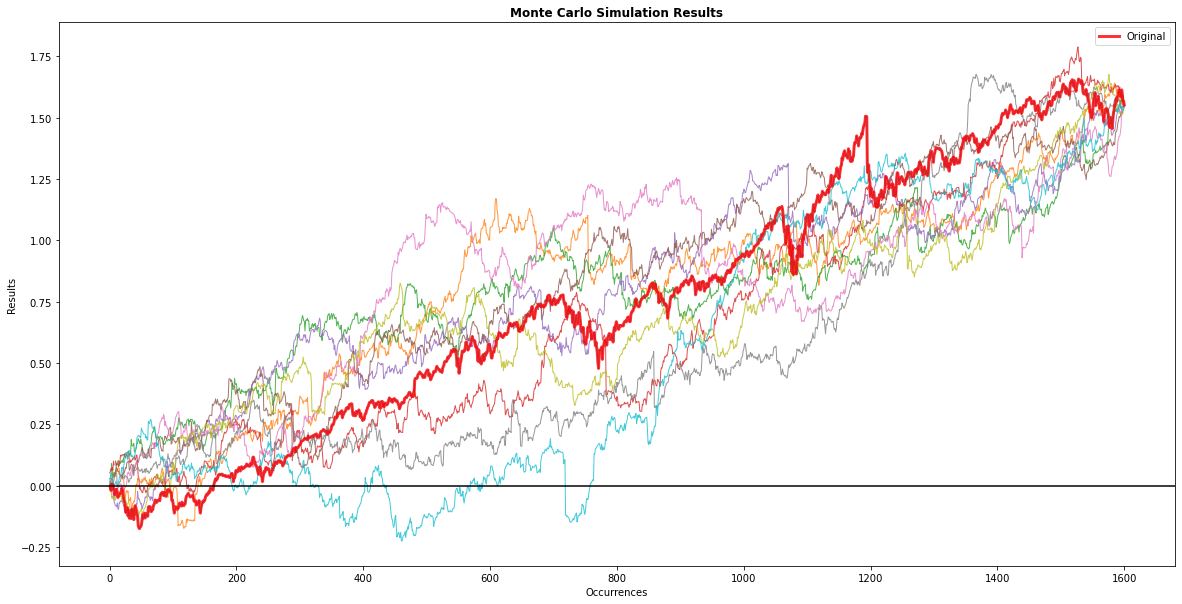

In [23]:
montecarlo_faangm = faangm_daily_returns['faangm'].montecarlo(sims=10, bust=-0.1, goal=1)
montecarlo_faangm.plot(figsize = (20, 10))